<a href="https://colab.research.google.com/github/Aparnak12/Team10-TextCaptcha/blob/main/captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive # include import statement
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/samples'

Mounted at /content/drive


In [3]:
images = []
filenames = []

for filename in os.listdir(dataset_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(dataset_path, filename)
        try:
            with Image.open(img_path) as img:
                images.append(img_path)
                filenames.append(filename)
        except IOError:
            pass

In [4]:
labels = [filename.split('.')[0] for filename in filenames]
characters = sorted(list(set(char for label in labels for char in label)))

In [5]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1070
Number of labels found:  1070
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [6]:
batch_size = 16
img_width = 200
img_height = 50

# We will employ two convolutional blocks, with each block incorporating a pooling layer that reduces the feature dimensions by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

max_len = max([len(label) for label in labels])

In [7]:
# Create a StringLookup layer that maps characters to numeric values.
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Create another StringLookup layer that maps numeric values back to characters.
# It inverts the mapping created by char_to_num.
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [8]:
# Splitting data into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)

In [9]:
# Processing an image and its label.
# Read and decode PNG or JPEG images, normalize and resize them, transpose dimensions, and convert the label to a numeric format.
def preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [10]:
# Define a function to configure the dataset
def configure_dataset(dataset):
    return dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create the training dataset, preprocess and configure it
images_labels_train = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
train_dataset = configure_dataset(images_labels_train)

# Create the test dataset, preprocess and configure it
images_labels_test = tf.data.Dataset.from_tensor_slices((images_test, labels_test))
test_dataset = configure_dataset(images_labels_test)

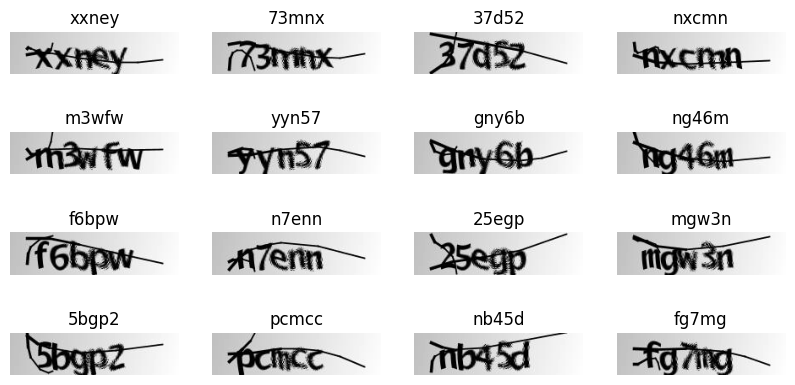

In [11]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
shuffled_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
random_batch = next(iter(shuffled_dataset.take(1)))
images = random_batch["image"]
labels = random_batch["label"]
for i in range(batch_size):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [12]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_len = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_len = label_len * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_len)
        self.add_loss(loss)
        return y_pred

In [13]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First Convolutional Block with LeakyReLU
    x = layers.Conv2D(
        32,
        (3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second Convolutional Block with LeakyReLU
    x = layers.Conv2D(
        64,
        (3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Reshape for Dense Layer
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # Dense Layer with LeakyReLU
    x = layers.Dense(96, name="dense1")(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = layers.Dropout(0.25)(x)

    # LSTM Layers
    x = layers.Bidirectional(layers.LSTM(160, return_sequences=True, dropout=0.3))(x)
    x = layers.Bidirectional(layers.LSTM(80, return_sequences=True, dropout=0.3))(x)

    # Output Layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="read_captcha"
    )

    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

In [14]:
model = build_model()
model.summary()

Model: "read_captcha"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 200, 50, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['leaky_re_lu[0][0]']         
                                                                                       

In [15]:
epochs = 100
patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=patience, restore_best_weights=True
)

In [16]:
log = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
47/47 [==============================] - 45s 715ms/step - loss: 20.9221 - val_loss: 16.4296
Epoch 2/100
47/47 [==============================] - 34s 719ms/step - loss: 16.3748 - val_loss: 16.4326
Epoch 3/100
47/47 [==============================] - 29s 613ms/step - loss: 16.3651 - val_loss: 16.4332
Epoch 4/100
47/47 [==============================] - 32s 685ms/step - loss: 16.3543 - val_loss: 16.4381
Epoch 5/100
47/47 [==============================] - 31s 661ms/step - loss: 16.3432 - val_loss: 16.4403
Epoch 6/100
47/47 [==============================] - 33s 712ms/step - loss: 16.3250 - val_loss: 16.4202
Epoch 7/100
47/47 [==============================] - 31s 652ms/step - loss: 16.3129 - val_loss: 16.4091
Epoch 8/100
47/47 [==============================] - 29s 609ms/step - loss: 16.2761 - val_loss: 16.3604
Epoch 9/100
47/47 [==============================] - 32s 680ms/step - loss: 16.2370 - val_loss: 16.3438
Epoch 10/100
47/47 [==============================] - 32s 676ms/

In [17]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 200, 50, 32)       0         
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100, 25, 64)       0         
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0     

In [18]:
def decode_batch_predictions(pred):
    input_length = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_length, greedy=True)[0][0][
        :, :max_len
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 [==============================] - 0s 219ms/step

Batch Prediction Accuracy: 100.00%



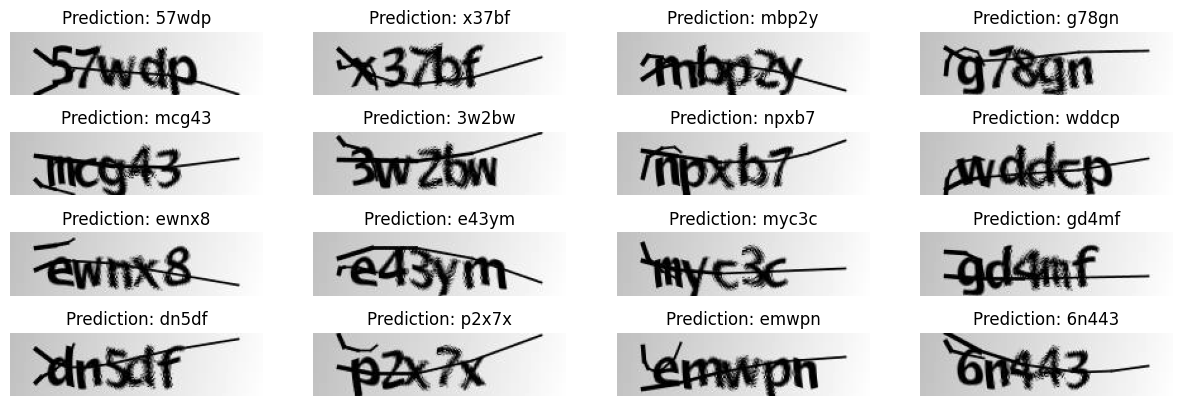

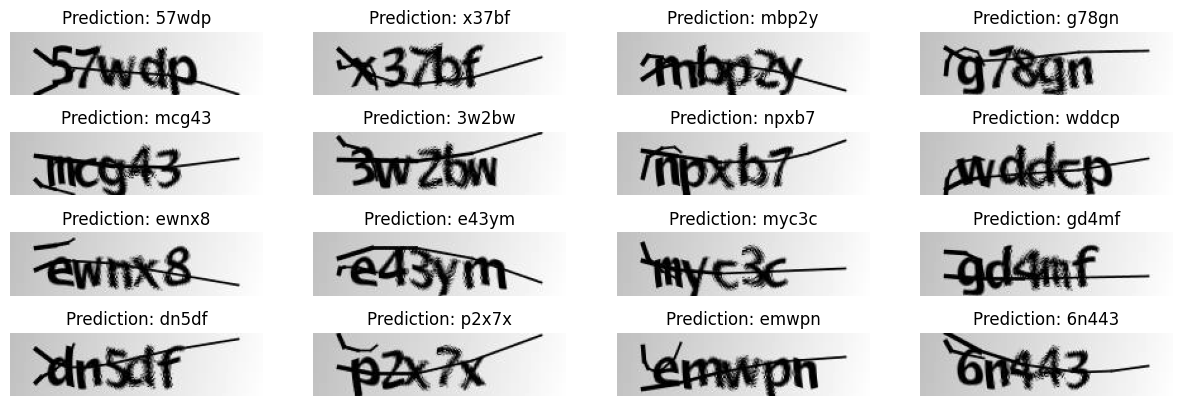

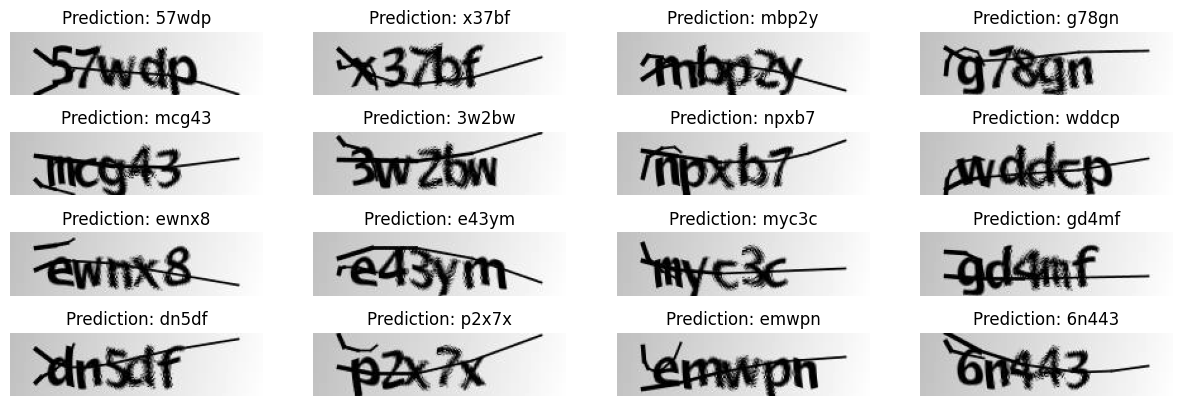

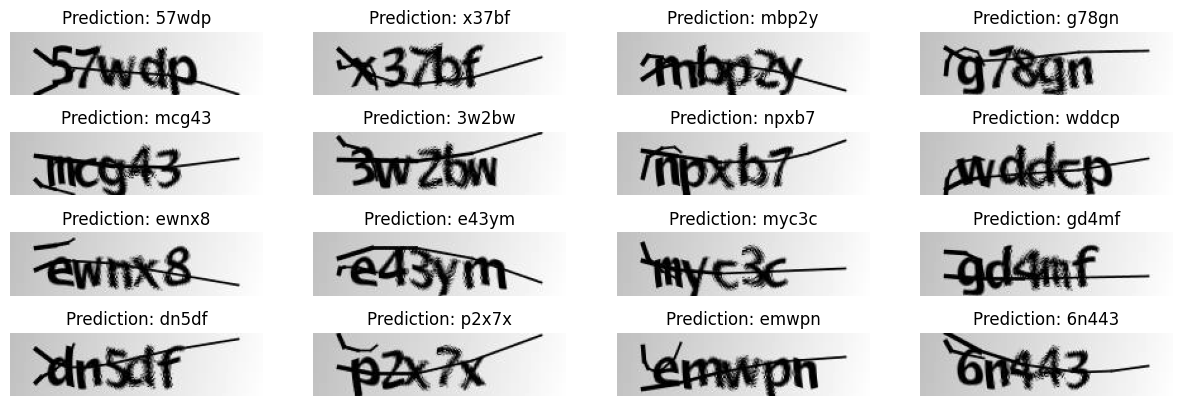

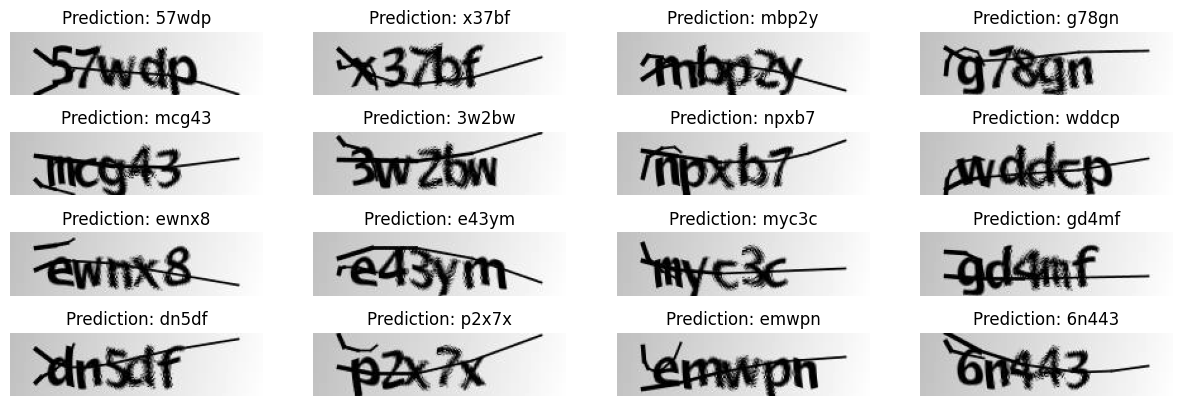

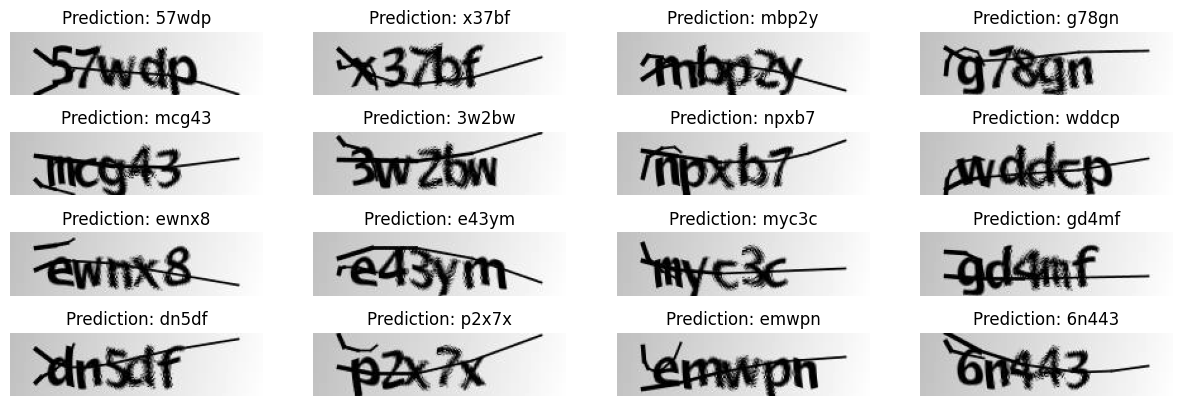

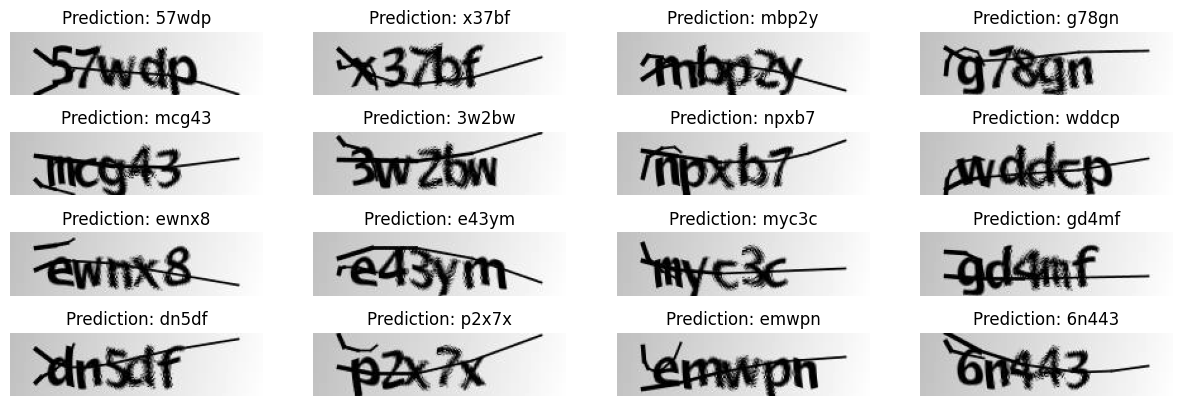

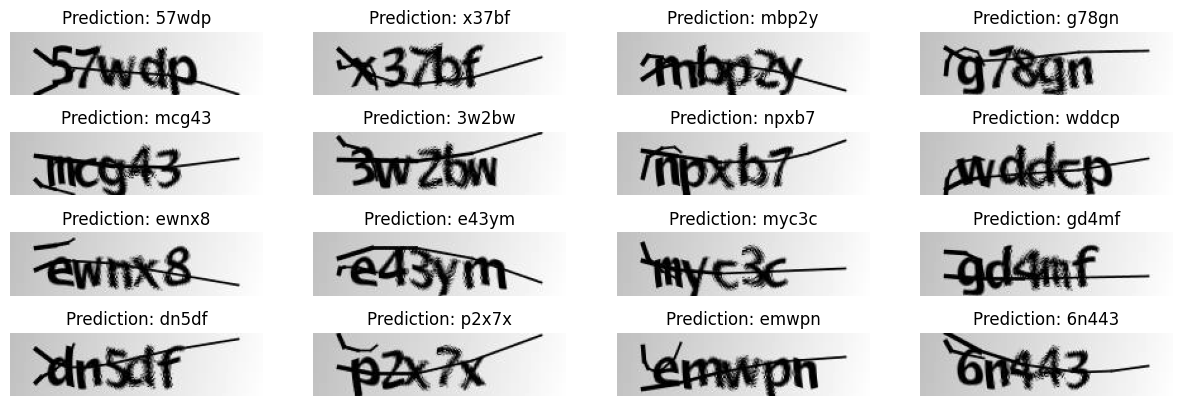

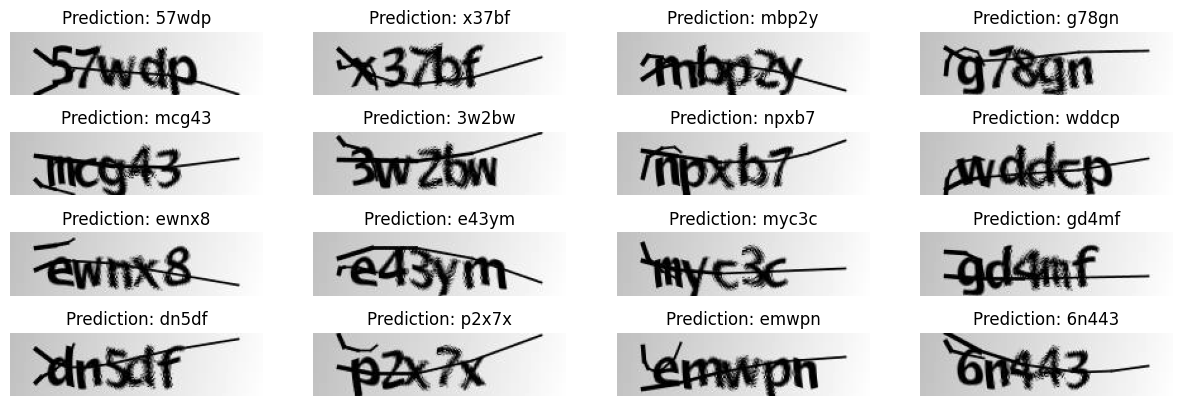

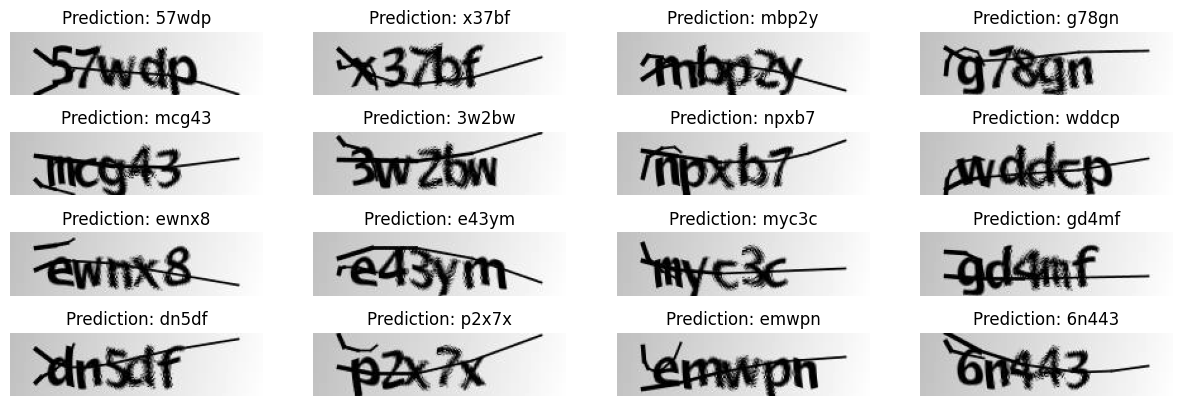

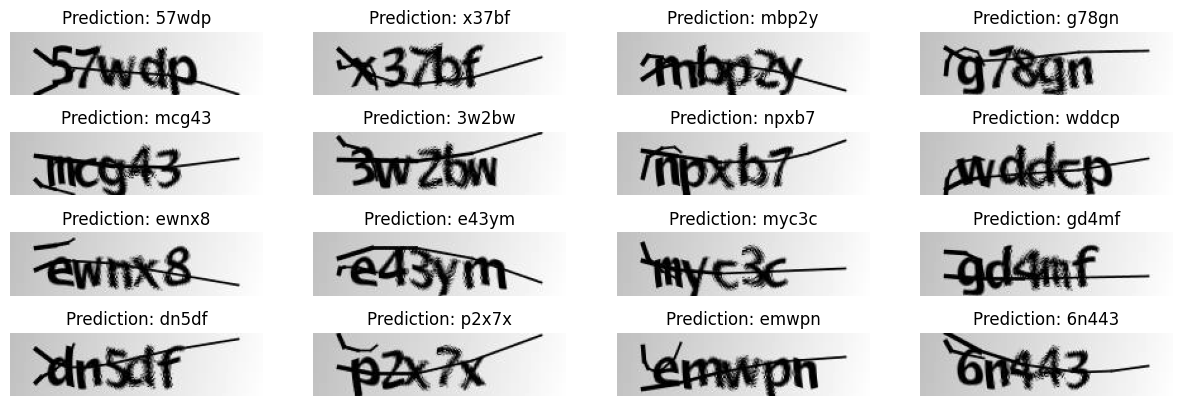

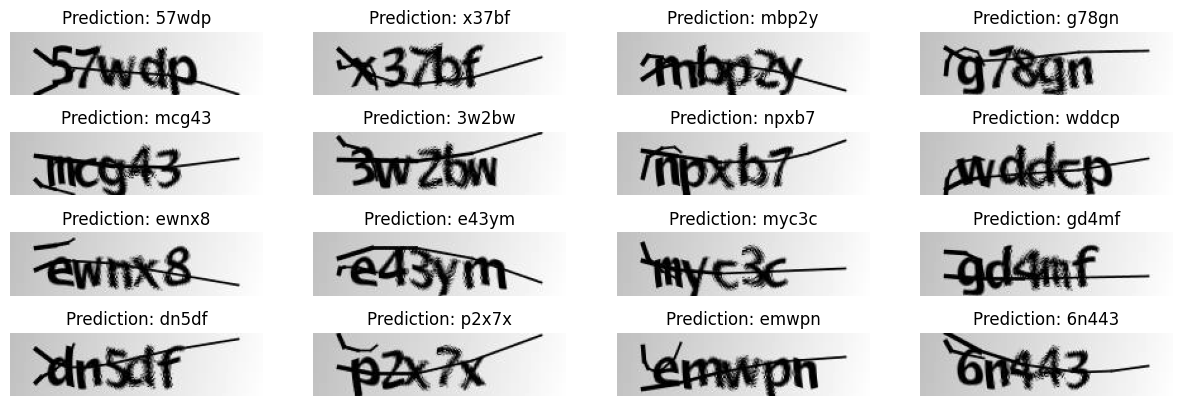

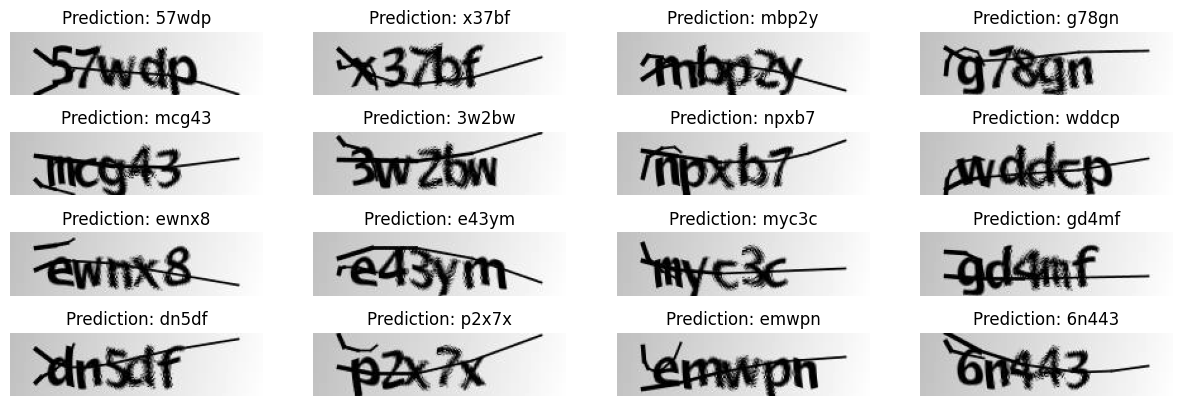

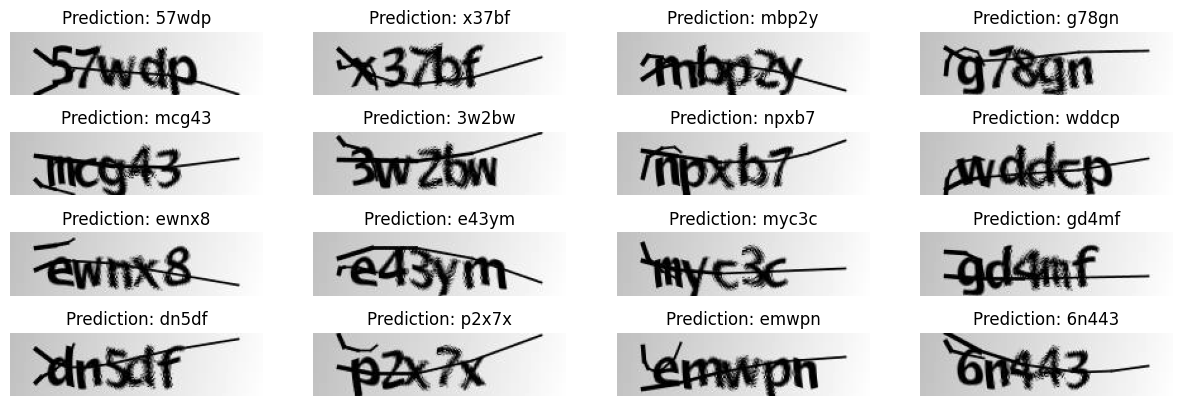

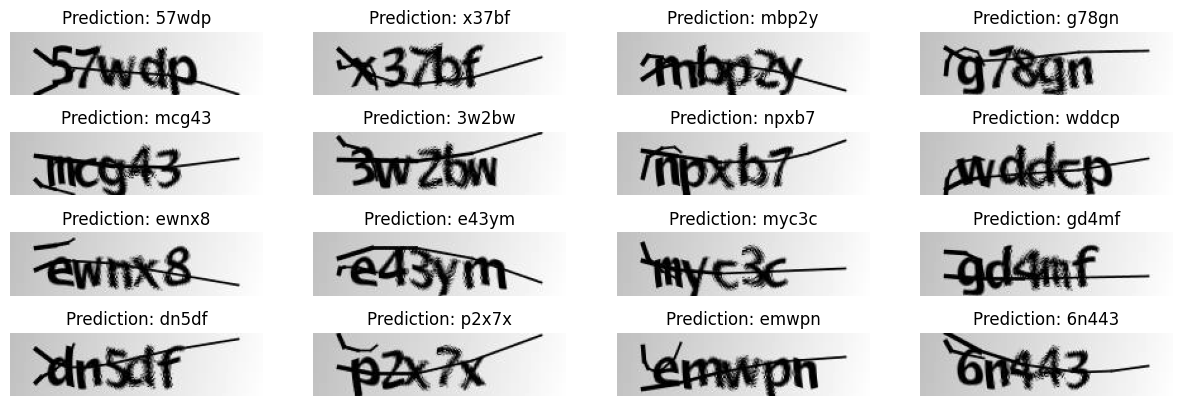

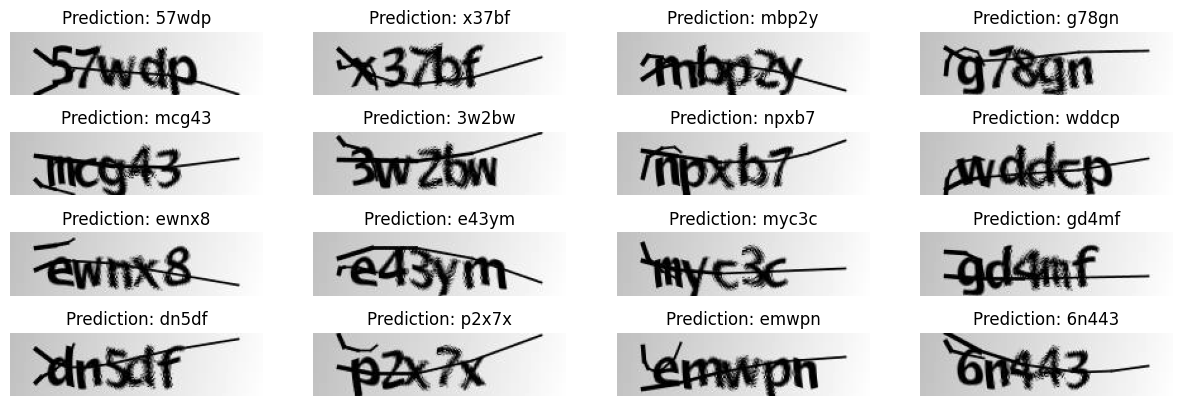

In [19]:
shuffled_dataset = test_dataset.shuffle(buffer_size=len(test_dataset))
random_batch = next(iter(shuffled_dataset.take(1)))
images = random_batch["image"]
labels = random_batch["label"]

for i in range(batch_size):

    preds = prediction_model.predict(images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    correct_predictions = 0

    for label in labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        if pred_texts[i] == orig_texts[i]:
          correct_predictions += 1
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

accuracy = correct_predictions / len(pred_texts)
print(f"\nBatch Prediction Accuracy: {accuracy * 100:.2f}%\n")

plt.show()

In [20]:
model.save('captcha.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
